# ExoComp

ExoComp is a set of tools for comparing/converting/interpreting measurements of the atmospheric composition of exoplanets. Here, we run a few test and example cases.

In [1]:
from exocomp import Abund
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt

## Estimate [M/H] and C/O from species abundances

ExoComp can fit a metallicity, C/O, and refractory-to-volatile ratio to measurements of species abundances. By species abundances, I mean measurements of the abundance of individual atomic or molecular species. Below, we show that given abundances of H$_2$O, CO, and CO$_2$ consistent with 10x solar metallicity and C/O = 0.5, we indeed get the expected values back.

p.s. For now, we're also assuming we're measuring an atmosphere at T=1000 K and at 1 bar... We'll come back to that...

H2O: -2.1421574047811496
CO: -3.6195294075315596
CO2: -5.523238093579142
Consider adding errors/uncertainty to the provided measurements!
---
Best fit [M/H]: 1.000  +/- 0.364
Best fit C/O: 0.100  +/- 0.039
---
Best Fit Abundances
---
H2O: -2.1421574047811482
CO: -3.6195294075315556
CO2: -5.523238093579146
Updating bulk abundances with mean/median fit


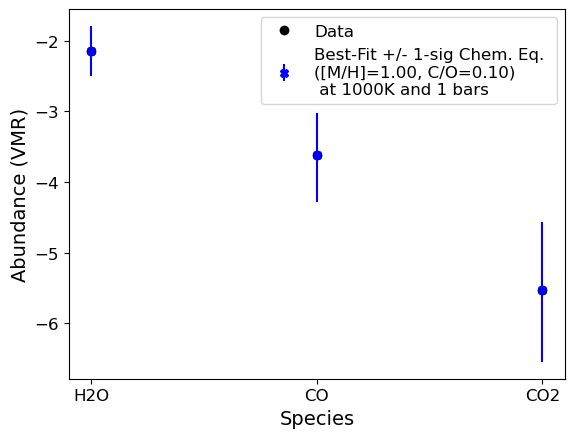

In [2]:
g = Abund()
test_abunds = g.predict_abund(1.0,0.1,1000,1,adjust_C=True,verbose=True)

#Setting abundances to fit to be those at 10x solar metallicity and C/O = 0.1
g.species_abunds = test_abunds
popt,pcov,best_fit_abunds = g.convert_species_abunds(1000, 1, plot_it=True) # Need to add errors or you get weird errorbars on M/H and C/O!

### What do we mean by metallicity and C/O?
Something that is sometimes overlooked is how exactly one defines metallicity and C/O. Metallicity is generally defined as a scaling of all elements heavier than He by some factor. But then, how does one change the C/O ratio? Some retrieval codes (PETRA, PLATON, POSEIDON) then change the C/H abundance to get the given C/O ratio, while other codes change O/H instead (pRT with pre-tabulated chemistry). The issue with this approach is that if C/O is changed after the metallicity has been set, then the new composition no longer reflects the correct metallicity! For example, in a low C/O scenario, if one sets C/H after the metallicity, then a whole bunch of carbon atoms have been removed, and the composition is now less metal enriched than it should be for the defined metallicity!

Many other codes (CHIMERA, PICASO) change the C/O in such a way that the overal metallicity remains unchanged. In a low C/O scenario, an equal number of carbon atoms are removed as oxygen atoms are added, keeping the number of atoms heavier the He the same, but lowering the C/O accordingly. Functionally:
```
total = O/H + C/H
C/H = C/O * total / (C/O + 1)
O/H = total / (C/O +1)            
```

Some other codes just retrieve O/H and C/H separately and quote a metallicity based one of them or their sum (ATMO, PETRA, pRT with easyCHEM) with the latter being equivalent to the above treatment.

In `ExoComp`, we can adjust how we define metallicity and C/O with the `adjust_C` parameter. By default, `ExoComp` changes the C/H ratio to adjust the C/O with `adjust_C = True`, meaning the metallicity is equivlanet to the O/H ratio. `adjust_C = False` will adjust the O/H ratio to match the C/O ratio instead and `adjust_C = 'Neither'` will adjust the C/O while conserving the total metallicity (so metallicity is basically [(O+C)/H].

Below, the point is illustrated with the example abundances above. Our test abundances were from 10x solar metallicity and C/O = 0.1, but this was defined by adjusting C/H to obtain the given C/O (ExoComp's default). But what if we used the other methods?

In [3]:
#Default: Adjust C/H to get C/O
print('\nAdjust C/H to get C/O:')
test_abunds = g.predict_abund(1.0,0.1,1000,1,adjust_C=True,verbose=True)

#Adjust O/H to get C/O
print('\nAdjust O/H to get C/O')
test_abunds = g.predict_abund(1.0,0.1,1000,1,adjust_C=False,verbose=True)

#Adjust C/O but preserve M/H constant
print('\nAdjust C/O, but preserve M/H')
test_abunds = g.predict_abund(1.0,0.1,1000,1,adjust_C='Neither',verbose=True)


Adjust C/H to get C/O:
H2O: -2.1421574047811496
CO: -3.6195294075315596
CO2: -5.523238093579142

Adjust O/H to get C/O
H2O: -1.373341211811521
CO: -2.49899037920934
CO2: -3.613169774701462

Adjust C/O, but preserve M/H
H2O: -1.9779812922018192
CO: -3.364948531045952
CO2: -5.102559414201636


They're so different! The different methods can result in almost 2 orders of magntiude difference in expected abundances for CO$_2$. What would the corresponding fits to metallicity and C/O be?

In [4]:
print('\nAdjust O/H to get C/O')
popt,pcov,best_fit = g.convert_species_abunds(1000, 1, plot_it=False, adjust_C=False) 

print('\nAdjust C/O, but preserve M/H')
popt,pcov,best_fit = g.convert_species_abunds(1000, 1, plot_it=False, adjust_C='Neither') 


Adjust O/H to get C/O
Consider adding errors/uncertainty to the provided measurements!
---
Best fit [M/H]: 0.301  +/- 2.417
Best fit C/O: 0.122  +/- 0.069
---
Best Fit Abundances
---
H2O: -2.1418731843048793
CO: -3.619246753587254
CO2: -5.523520256523907
Updating bulk abundances with mean/median fit

Adjust C/O, but preserve M/H
Consider adding errors/uncertainty to the provided measurements!
---
Best fit [M/H]: 0.836  +/- 0.112
Best fit C/O: 0.108  +/- 0.049
---
Best Fit Abundances
---
H2O: -2.1420455056207564
CO: -3.619418336284168
CO2: -5.523348998985355
Updating bulk abundances with mean/median fit


We can obtain the same species abundances, but the metallicity or C/O we infer is wildly different from the 10x solar and 0.1 C/O we input using the other C/O definition!

### Adding uncertainties into our measurements

Any good measurement will have an associated uncertainty. We can incorporate these into our fits. ``exocomp`` handles symmetric errors, asymmetric errors, and the ability to input posterior samples. The latter can take a bit of computation if there are lots of samples because it is using curve_fit to fit each sample. You can reduce the number of fitted samples by defining ``posterior_samples``. Let's take a look:

---
Best fit [M/H]: 1.001  +/- 0.001
Best fit C/O: 0.500  +/- 0.090
---
Best Fit Abundances
---
H2O: -2.1964554328171007
CO: -2.955597565466063
CO2: -4.911827315520034
Chi^2 = 2.6335580486130354e-11, Reduced Chi^2 = 1.3167790243065177e-11
Updating bulk abundances with mean/median fit


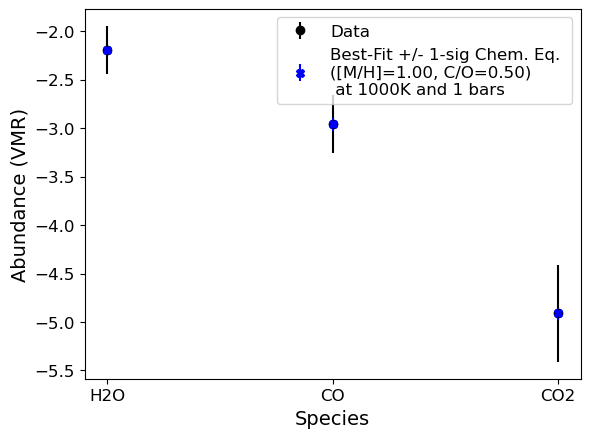

In [5]:
# Symmetric errors
g = Abund(species_abunds={'H2O': -2.196454926078874, 'CO': -2.95559683423187, 'CO2': -4.9118293333092335},
          species_errs={'H2O': 0.25, 'CO': 0.3, 'CO2': 0.5})
popt,pcov,best_fit_abunds = g.convert_species_abunds(1000, 1, plot_it=True)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 37
         Function evaluations: 72
---
Best fit [M/H]: 1.001 
Best fit C/O: 0.500
Chi^2 = 39896627.976812825, Reduced Chi^2 = 19948313.988406412
---
Best Fit Abundances
---
H2O: -2.196470516906127
CO: -2.955595590742825
CO2: -4.911840480278904
Updating bulk abundances with mean/median fit


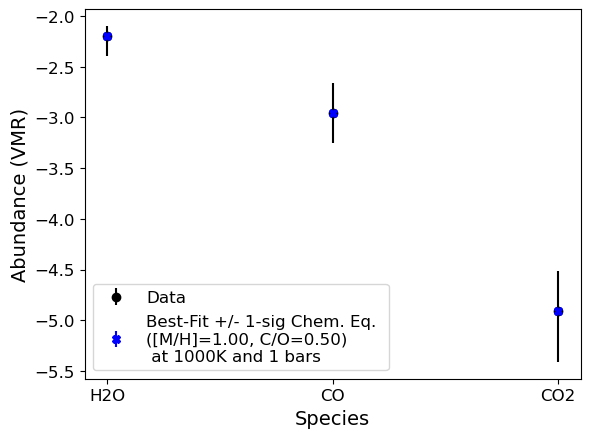

In [6]:
# Asymmetric errors - will use scipy.optimize.fmin rather than curve_fit
g = Abund(species_abunds={'H2O': -2.196454926078874, 'CO': -2.95559683423187, 'CO2': -4.9118293333092335},
          species_errs={'H2O': [0.2,0.1], 'CO': [0.3,0.3], 'CO2': [0.5,0.4]})
popt,pcov,best_fit_abunds = g.convert_species_abunds(1000, 1, plot_it=True)

Running on 250 samples... May take a moment if >10
---
Metallicity - Median: 1.0131, Lower bound: 0.9194, Upper bound: 1.0909
C/O - Median: 0.5235, Lower bound: 0.3228, Upper bound: 0.8531
---
Median Fit Abundances
---
H2O: -2.189510633787311
CO: -2.917582933799567
CO2: -4.866574833053162
Updating bulk abundances with mean/median fit


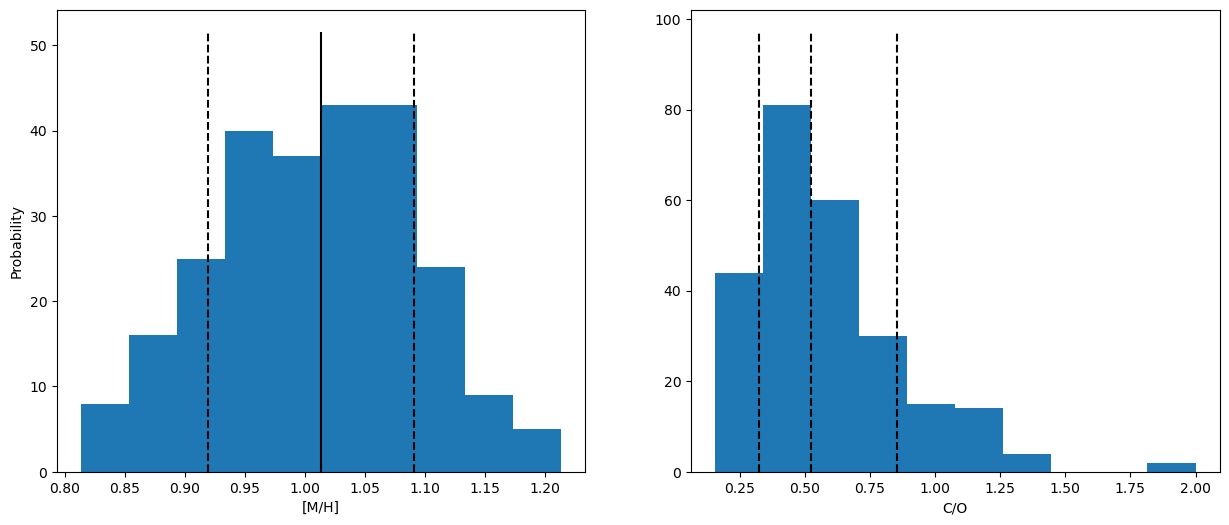

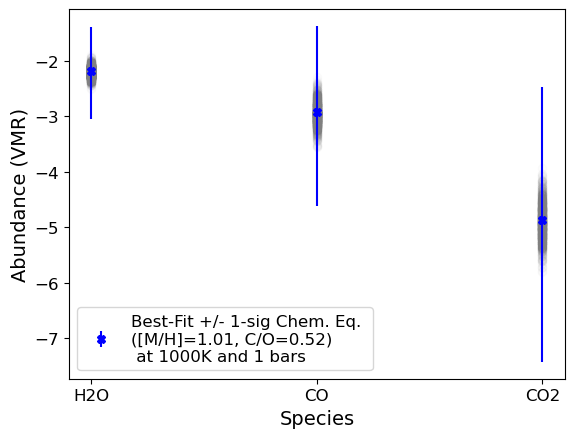

In [7]:
# Posterior samples
h2o_err = np.random.normal(-2.2,0.1,1000)
co_err = np.random.normal(-2.96,0.2,1000)
co2_err = np.random.normal(-4.91,0.3,1000)

g = Abund(species_abunds={'H2O': -2.196454926078874, 'CO': -2.95559683423187, 'CO2': -4.9118293333092335},
          species_errs={'H2O': h2o_err, 'CO': co_err, 'CO2': co2_err})
popt,pcov,best_fit_abunds = g.convert_species_abunds(1000, 1, plot_it=True, posterior_samples=250) # Doesn't matter if C/O adjusts C or O here

### Adding refractories

Many folks [1,2,3,4] have pointed out the utility of measuring refractory elements to understand processes like 1) cloud formation, 2) rainout, and 3) planet formation. With ``exocomp``, we can add measurements of any refractory element (basically anything past oxygen on the periodic table) to constrain the refractory-to-volatile ratio by setting ``fit_refvol=True``. We can also just use the additional measurements to further constrain the metallicity. Both cases are shown below.

---
Best fit [M/H]: 0.840  +/- 0.000
Best fit C/O: 0.195  +/- 0.000
---
Best Fit Abundances
---
H2O: -2.412509501890642
CO: -2.8886459009876395
CO2: -5.634250796916242
S: -8.570147778058422
Na: -4.600509266923658
Chi^2 = 8.166659576685687, Reduced Chi^2 = 2.0416648941714217
Updating bulk abundances with mean/median fit


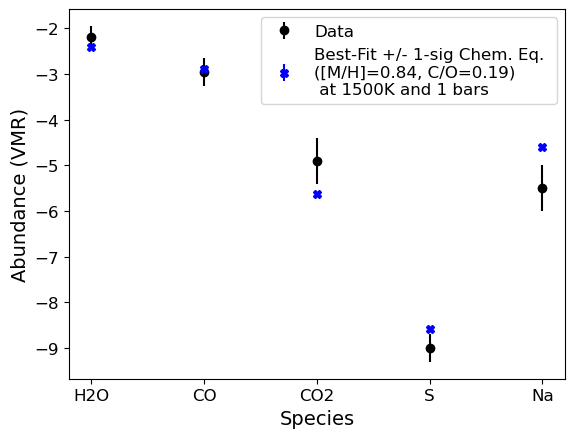

In [8]:
# Using Sulfur and Sodium to further constrain the metallicity
# Symmetric errors
g = Abund(species_abunds={'H2O': -2.20, 'CO': -2.96, 'CO2': -4.91,'S':-9.0,'Na':-5.5},
          species_errs={'H2O': 0.25, 'CO': 0.3, 'CO2': 0.5, 'S':0.3, 'Na':0.5})
popt,pcov,best_fit_abunds = g.convert_species_abunds(1500, 1, plot_it=True) # We need to increase the temperature so S is not condensed...

---
Best fit [M/H]: 1.003  +/- 0.001
Best fit C/O: 0.153  +/- 0.000
Best fit R/V: -0.720  +/- 0.009
---
Best Fit Abundances
---
H2O: -2.1083272717499386
CO: -2.830104807053188
CO2: -5.269691817477281
S: -9.123688062018834
Na: -5.156299085472343
Chi^2 = 1.4819574015800352, Reduced Chi^2 = 0.3704893503950088
Updating bulk abundances with mean/median fit


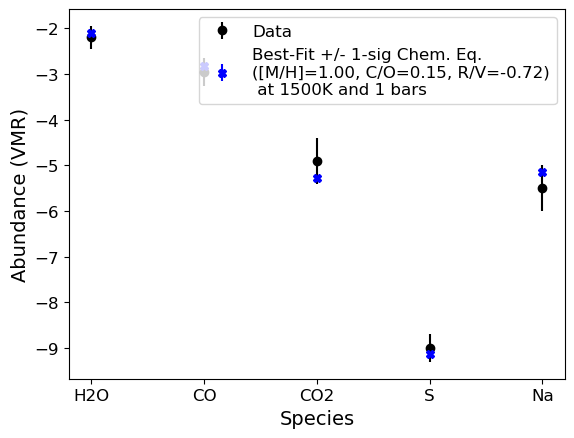

In [9]:
# Using Sulfur to further co
# Symmetric errors
g = Abund(species_abunds={'H2O': -2.20, 'CO': -2.96, 'CO2': -4.91,'S':-9.0,'Na':-5.5},
          species_errs={'H2O': 0.25, 'CO': 0.3, 'CO2': 0.5, 'S':0.3, 'Na':0.5})
popt,pcov,best_fit_abunds = g.convert_species_abunds(1500, 1, plot_it=True, fit_refvol=True) # Doesn't matter if C/O adjusts C or O here

## Changing our solar reference abundances

Metallicity, as defined here, is always relative to a reference abundance. Usually this is "solar composition" of some variety, but sometimes we have enough information about the host star to use the stellar abundances as our reference. Unfortunately, if we want to compare retrieval results, the reference abundances used in various studies or retrieval codes varies considerably!

When it comes to solar abundances, many references exist. ``ExoComp`` has abundances from Lodders et al. 2010, 2021, and 2025, Asplund et al. 2005, 2009, 2021, and Caffau et al. 2011. These are listed in ``exocomp.Abund.possible_solars``. In ``exocomp.Abund.define_stellar``, one can input any known stellar elemental abundances to be used in the calculations (whatever is defined in ``exocomp.Abund.stellar`` will be used for anything not defined).

Let's look at our example at 10x solar metallicity and $\mathrm{C/O} = 0.1$, but with different solar abundances. The default we've been using so far is the most recent reference, Lodders et al. 2025. Again, the default treatment of C/O is to vary C/H.

In [10]:
# Our original example used Lodders+ 2025 to get abundances of H2O, CO, and CO2 at 10x solar metallicity and C/O=0.1
# Again at 1000 K and 1 bar
print('Lodders+ 2025')
g = Abund(species_abunds={'H2O': -2.196454926078874, 'CO': -2.95559683423187, 'CO2': -4.9118293333092335},
          species_errs={'H2O': 0.1, 'CO': 0.1, 'CO2': 0.1}, solar='Lodders25')
popt,pcov,best_fit_abunds = g.convert_species_abunds(1000, 1, plot_it=False)

print('\nAsplund+ 2009')
g = Abund(species_abunds={'H2O': -2.196454926078874, 'CO': -2.95559683423187, 'CO2': -4.9118293333092335},
          species_errs={'H2O': 0.1, 'CO': 0.1, 'CO2': 0.1}, solar='Asplund09')
popt,pcov,best_fit_abunds = g.convert_species_abunds(1000, 1, plot_it=False)

print('\nLodders+ 2010')
g = Abund(species_abunds={'H2O': -2.196454926078874, 'CO': -2.95559683423187, 'CO2': -4.9118293333092335},
          species_errs={'H2O': 0.1, 'CO': 0.1, 'CO2': 0.1}, solar='Lodders10')
popt,pcov,best_fit_abunds = g.convert_species_abunds(1000, 1, plot_it=False)


Lodders+ 2025
---
Best fit [M/H]: 1.001  +/- 0.000
Best fit C/O: 0.500  +/- 0.002
---
Best Fit Abundances
---
H2O: -2.196456010547247
CO: -2.9555979209728966
CO2: -4.911828253745222
Chi^2 = 3.522536165426771e-10, Reduced Chi^2 = 1.7612680827133854e-10
Updating bulk abundances with mean/median fit

Asplund+ 2009
---
Best fit [M/H]: 1.058  +/- 0.000
Best fit C/O: 0.529  +/- 0.002
---
Best Fit Abundances
---
H2O: -2.193703402171143
CO: -2.9528386553972754
CO2: -4.914568928043371
Chi^2 = 0.0022683813605737756, Reduced Chi^2 = 0.0011341906802868878
Updating bulk abundances with mean/median fit

Lodders+ 2010
---
Best fit [M/H]: 1.095  +/- 0.000
Best fit C/O: 0.521  +/- 0.002
---
Best Fit Abundances
---
H2O: -2.193696515820324
CO: -2.9528316475014313
CO2: -4.914575904597135
Chi^2 = 0.0022798738648195493, Reduced Chi^2 = 0.0011399369324097746
Updating bulk abundances with mean/median fit


### Case Study: WASP-77A b
Let's look at a real-world example of this. Line et al. 2022 measured relatively high precision oxygen and carbon abundances in WASP-77Ab.

In [11]:
from exocomp import Abund
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt

# initialize Abund instance with retrieval defined so we get correct mh_type and co_type
g = Abund(retrieval='CHIMERA',solar = 'Asplund09')
#display(g.solar_abundances_orig)

# convert bulk abundances to elemental abundances
#g.convert_bulk_abundance(-0.48,0.59,mh_err=[0.12,0.14],co_err=[0.08,0.08],solar = 'Asplund09') 
g.convert_bulk_abundance(-0.41,0.46,mh_err=[0.14,0.14],co_err=[0.08,0.08],solar = 'Asplund09') #Accounting for rainout

print('Asplund+ 2009 Solar Abundances')
print(f'[O/H] = {g.bulk_abunds['O']-g.solar_abundances['O'][0]} +/- {np.max(g.bulk_errs['O'])}')
print(f'[C/H] = {g.bulk_abunds['C']-g.solar_abundances['C'][0]} +/- {np.max(g.bulk_errs['C'])}')
print(f'C/O = {10**g.bulk_abunds['C']/10**g.bulk_abunds['O']} +/- 0.08') #C/O errors not saved elsewhere
print(f'C/O_* = {(10**g.solar_abundances['C'][0]/10**g.solar_abundances['O'][0])}')
print(f'C/O/C/O_* = {(10**g.bulk_abunds['C']/10**g.bulk_abunds['O'])/(10**g.solar_abundances['C'][0]/10**g.solar_abundances['O'][0])}')

solar_ratios, solar_ratios_err = g.solar_ratio_calc()
print(solar_ratios['O'],solar_ratios['C'])
print(10**solar_ratios['C']/10**solar_ratios['O'])
print(solar_ratios_err['O'],solar_ratios_err['C'])


# redefine solar based on Reggiani et al. 2022
# doesn't use the errors for now
g.define_stellar({'O':(8.92,0.23),'C':(8.56,0.1)})

print('Reggiani+ Stellar Abundances')
print(f'[O/H] = {g.bulk_abunds['O']-g.solar_abundances['O'][0]} +/- {np.max(g.bulk_errs['O'])}')
print(f'[C/H] = {g.bulk_abunds['C']-g.solar_abundances['C'][0]} +/- {np.max(g.bulk_errs['C'])}')
print(f'C/O = {10**g.bulk_abunds['C']/10**g.bulk_abunds['O']} +/- 0.08') #C/O errors not saved elsewhere
print(f'C/O_* = {(10**g.solar_abundances['C'][0]/10**g.solar_abundances['O'][0])}')
print(f'C/O/C/O_* = {(10**g.bulk_abunds['C']/10**g.bulk_abunds['O'])/(10**g.solar_abundances['C'][0]/10**g.solar_abundances['O'][0])}')

solar_ratios, solar_ratios_err = g.solar_ratio_calc()
print(solar_ratios['O'],solar_ratios['C'])
print(10**solar_ratios['C']/10**solar_ratios['O'])
print(solar_ratios_err['O'],solar_ratios_err['C'])
0.44*1.4

Using Asplund09 solar abundances
Asplund+ 2009 Solar Abundances
[O/H] = -0.3841498192190116 +/- 0.14
[C/H] = -0.4613919875374384 +/- 0.14
C/O = 0.45999999999999935 +/- 0.08
C/O_* = 0.5495408738576247
C/O/C/O_* = 0.837062394960591
-0.3841498192190116 -0.4613919875374384
0.8370623949605908
0.14866068747318506 0.14866068747318506
Reggiani+ Stellar Abundances
[O/H] = -0.614149819219012 +/- 0.14
[C/H] = -0.5913919875374392 +/- 0.14
C/O = 0.45999999999999935 +/- 0.08
C/O_* = 0.43651583224016655
C/O/C/O_* = 1.0537991202731727
-0.614149819219012 -0.5913919875374392
1.0537991202731727
0.26925824035672524 0.17204650534085256


0.616

This is a super interesting case, where if we compared WASP-77Ab's C/O measurement to solar abundances, we would conclude that it has a C/O consistent with solar. But if we compare the C/O in the planet to new, state-of-the-art measurements of the C/O ratio of the star, then we see that the planet is actually more highly enriched in carbon!

** wait, why is C/O ratio of the planet different? It should be the same.

## Sensitivity to Temperature and Pressure

A given metallicity and C/O ratio will correspond to a different set of species abundances depending on the temperature and pressure of an atmosphere. The two biggest reasons are the CH$_4$-to-CO transition from low-to-high temperatures and thermal dissociation of molecules at high temperatures. You can see both these at work in the plots below, showing how abundances change at 10 times solar metallicity 1) at 1 mbar as a function of temperture and 2) at 1000 K as a function of pressure.

There will be a sweet-spot where we can be a bit more confident in our inferences because the chemistry isn't quite so sensitive to the assumed pressure and temperature. For example, above 1000 K, we can be confident that we're safely in the CO-dominated regime and below 2500 K, we can be confident that we're not subject to much thermal dissociation. As with this whole exercise, disequilbrium chemistry processes like vertical mixing and photochemistry can also influence our inferences, so be aware of that too.

Text(0, 0.5, 'Abundance')

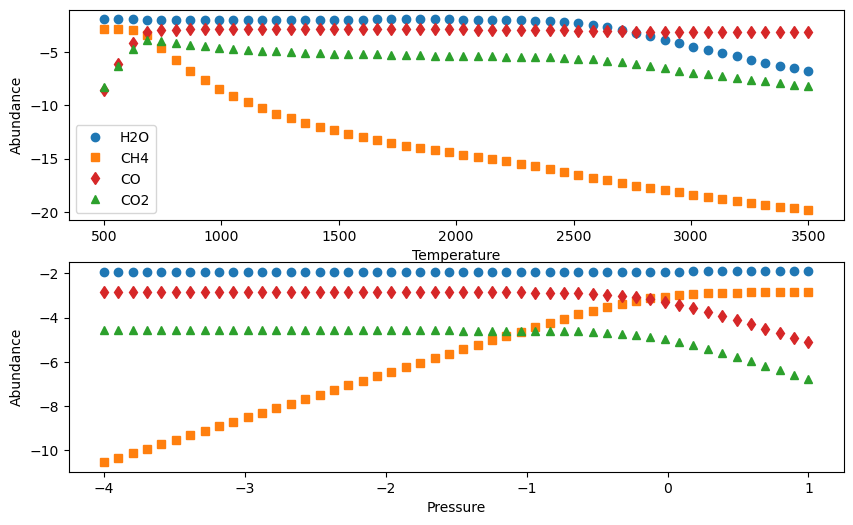

In [12]:
temps = np.linspace(500,3500)
pressures = np.linspace(-4,1)
cs = ['#1f77b4', '#ff7f0e', '#d62728','#2ca02c', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'] #colors

fig,ax = plt.subplots(2,1,figsize=(10,6))
for i,t in enumerate(temps):
    test_abunds = g.predict_abund(1.0,0.1,t,1e-3,adjust_C=True,verbose=False,species=['H2O','CO','CO2','CH4'])
    ax[0].plot(t,test_abunds['H2O'],'o',color=cs[0],label = 'H2O' if i == 0 else '')
    ax[0].plot(t,test_abunds['CH4'],'s',color=cs[1],label = 'CH4' if t == np.min(temps) else '')
    ax[0].plot(t,test_abunds['CO'],'d',color=cs[2],label = 'CO' if t == np.min(temps) else '')
    ax[0].plot(t,test_abunds['CO2'],'^',color=cs[3],label = 'CO2' if t == np.min(temps) else '')

ax[0].set_xlabel('Temperature')
ax[0].set_ylabel('Abundance')
ax[0].legend()

for p in pressures:
    test_abunds = g.predict_abund(1.0,0.1,1000,10**p,adjust_C=True,verbose=False,species=['H2O','CO','CO2','CH4'])
    ax[1].plot(p,test_abunds['H2O'],'o',color=cs[0],label = 'H2O' if t == np.min(temps) else '')
    ax[1].plot(p,test_abunds['CH4'],'s',color=cs[1],label = 'CH4' if t == np.min(temps) else '')
    ax[1].plot(p,test_abunds['CO'],'d',color=cs[2],label = 'CO' if t == np.min(temps) else '')
    ax[1].plot(p,test_abunds['CO2'],'^',color=cs[3],label = 'CO2' if t == np.min(temps) else '')

ax[1].set_xlabel('Pressure')
ax[1].set_ylabel('Abundance')

Thus, on the flip-side, our inference of the metallicity and C/O will change for a given set of species abundances, depending on the pressure and temperature that we assume those abundances are representative of. Below, you can see that assuming a (very) wrong temperature will give us the wrong metallicity and C/O and abundances that don't fit very well! 

Assuming the wrong pressure is a little more forgiving, but our C/O estimate is off by a factor of four because there's actually more CH$_4$ and less CO and CO$_2$ at depth. Remember what we said above though, and if you chose to define C/O differently, you'll be biased in a different way! The only reason our metallicity didn't change when assuming a different pressure was because H$_2$O is relatively robust to pressure in this temperature regime and the metallicity was essentially defined as [O/H]. If we define things differently, our estimates are even more messed up.

In [13]:
# Assume our fiducial 10x solar metallicity, C/O = 0.1, T=1000K and pressure = 1bar
test_abunds = g.predict_abund(1.0,0.1,1000,1,adjust_C=True,verbose=False)

g = Abund(species_abunds=test_abunds,
          species_errs={'H2O': 0.1, 'CO': 0.1, 'CO2': 0.1}, solar='Lodders25')

print('Fitting for bulk abundances at the correct T=1000K and P=1bar')
popt,pcov,best_fit_abunds = g.convert_species_abunds(1000, 1, plot_it=False)

print('\nFitting for bulk abundances at the wrong T=3000K')
popt,pcov,best_fit_abunds = g.convert_species_abunds(3000, 1, plot_it=False)

print('\nFitting for bulk abundances at the wrong P=1e-4 bar')
popt,pcov,best_fit_abunds = g.convert_species_abunds(1000, 1e-4, plot_it=False)

print('\nFitting for bulk abundances at the wrong P=1e-4 bar, defining C/O by O/H')
popt,pcov,best_fit_abunds = g.convert_species_abunds(1000, 1e-4, plot_it=False, adjust_C=False)

print('\nFitting for bulk abundances at the wrong P=1e-4 bar, defining C/O consistently with M/H')
popt,pcov,best_fit_abunds = g.convert_species_abunds(1000, 1e-4, plot_it=False, adjust_C='Neither')

Fitting for bulk abundances at the correct T=1000K and P=1bar
---
Best fit [M/H]: 1.219  +/- 0.000
Best fit C/O: 0.085  +/- 0.000
---
Best Fit Abundances
---
H2O: -1.9269685283939144
CO: -3.3145903720687953
CO2: -4.999774192669719
Chi^2 = 0.002798471471121238, Reduced Chi^2 = 0.001399235735560619
Updating bulk abundances with mean/median fit

Fitting for bulk abundances at the wrong T=3000K
---
Best fit [M/H]: 1.531  +/- 0.000
Best fit C/O: 0.033  +/- 0.000
---
Best Fit Abundances
---
H2O: -1.6024375664538895
CO: -3.004024008397868
CO2: -5.309866587763058
Chi^2 = 29.21826991328298, Reduced Chi^2 = 14.60913495664149
Updating bulk abundances with mean/median fit

Fitting for bulk abundances at the wrong P=1e-4 bar
---
Best fit [M/H]: 1.219  +/- 0.000
Best fit C/O: 0.031  +/- 0.000
---
Best Fit Abundances
---
H2O: -1.926799365189687
CO: -3.314416514885071
CO2: -4.999944236575657
Chi^2 = 0.0024938703370249184, Reduced Chi^2 = 0.0012469351685124592
Updating bulk abundances with mean/median 

In the near-future, we will implement the ability to incorporate uncertainties in the temperature and pressure into the errors of the inferred bulk abundances.

## Some Real-world Examples
### WASP-17b

Let's look at an actual example. Louie et al. 2025 

Optimization terminated successfully.
         Current function value: 2.582299
         Iterations: 96
         Function evaluations: 175
---
Best fit [M/H]: 0.199 
Best fit C/O: 0.259
Best fit R/V: -1.723
Chi^2 = 22435859.901501104, Reduced Chi^2 = 4487171.980300221
---
Best Fit Abundances
---
H2O: -2.949872113423779
CH4: -9.22139631515651
CO2: -6.493406871936959
K: -8.27712436384943
Na: -6.962253111780037
CO: -3.403823942828767
Updating bulk abundances with mean/median fit


(array([ 0.19873071,  0.25914658, -1.72293022]),
 None,
 array([-2.94987211, -9.22139632, -6.49340687, -8.27712436, -6.96225311,
        -3.40382394]))

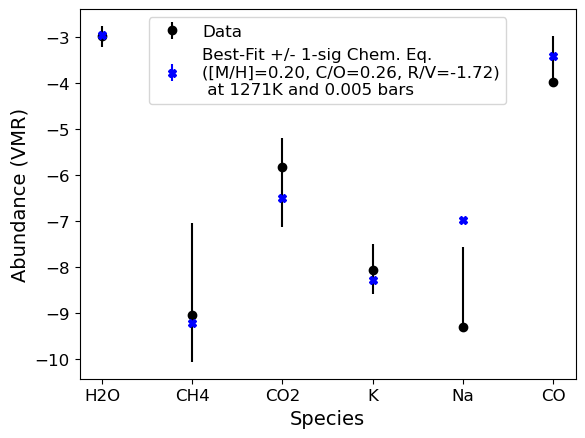

In [14]:
#WASP-17b
                      
g = Abund(species_abunds={'H2O':-2.96,'CH4':-9.05,'CO2':-5.81,'K':-8.07,'Na':-9.31,'CO':-3.97},
          species_errs={'H2O':[0.24,0.21],'CH4':[1.01,2.01],'CO2':[1.31,0.62],'K':[0.52,0.58],'Na':[0,1.75],'CO':[0,1.0]})
g.convert_species_abunds(1271, 5e-3,plot_it=True,fit_refvol=True)
#g.convert_species_abunds(1271, 5e-3,plot_it=True,fit_refvol=False,adjust_C=False)
#g.convert_species_abunds(1271, 5e-3,plot_it=True,fit_refvol=False,adjust_C='Neither')


### WASP-178b

WASP-178b is an ultra-hot Jupiter with an observed transit spectrum ranging from 0.2 to 5.1 $\mu$m, with detections of refractories and volatiles. Here, we mostly ascribe the large NUV absorption to SiO, but not that it could also be from atomic species like Fe and Mg (and their ions), or some combination of each. In any case, we show here the constraints we would place on the bulk abundances from results from a free retrieval (with posteriors!) and compare them to an equivalent chemical equilibrium retrieval. Remember, as above, the challenge for ultra-hot Jupiters is dealing with thermal dissociation, where some (or lots) of the H$_2$O will have dissociated, making it challenging to infer a bulk O/H from measurements of H$_2$O.

These retrievals correspond to the isothermal free retrieval case for the combined HST+JWST dataset from Lothringer et al. 2025. These retrievals were run with pRT, so let's take the posterior, for which the abundances will be in mass fractions, convert them to volume mixing ratios with ``ExoComp``, and fit bulk abundances to them. The standard deviation of the posterior is used as a weight for the fits to each sample- otherwise unconstrained species blow up the constraint on the bulk abundances (the same problem when trying to infer bulk abundances by adding up atoms per species!).

In [15]:
samples_free = np.genfromtxt('W178_eqchem_JWST_retrieval_10bin_1000LP_iso_new_offs_hot_post_equal_weights.dat')

#Columns are: UV offset, IR offset, radius, temperature, log10Pcloud, H2O, CO, CO2, FeH, SiO, TiO, VO, Fe, Fe+, Mg, Mg+
species = ['H2O','CO','CO2','FeH', 'SiO', 'TiO', 'VO', 'Fe', 'Fe+', 'Mg', 'Mg+']
# Unfortunately, these ion species are not included in EasyChem by default
# They can be added manually though with the right thermochemical info
not_included = ['Fe+','Mg+']
offset = 5
posterior_dict_mmw = {}
for i,s in enumerate(species):
    if s in not_included:
        continue
    posterior_dict_mmw[s] = samples_free[:,offset+i]

g = Abund()
posterior_dict_vmr = g.MMR_to_VMR(posterior_dict_mmw, mmw=2.3)

# Make a dict of the median values to input into ExoComp- only used for reference,
# it is the posteriors that matter!
median_dict = {}
for i,s in enumerate(species):
    if s in not_included:
        continue
    median_dict[s] = np.median(posterior_dict_vmr[s])
print('Median VMRs:')
print(median_dict)

Median VMRs:
{'H2O': -6.259975908812065, 'CO': -5.441280282739208, 'CO2': -9.6259416793431, 'FeH': -6.399704413781108, 'SiO': -5.084753936621808, 'TiO': -10.732461397889557, 'VO': -10.288929797996929, 'Fe': -6.447413285227768, 'Mg': -6.000271813664576}


Running on 250 samples... May take a moment if >10
---
Metallicity - Median: 0.6662, Lower bound: 0.5327, Upper bound: 0.8107
C/O - Median: 0.0018, Lower bound: 0.0011, Upper bound: 0.0026
Ref/Vol - Median: -1.3555, Lower bound: -1.5423, Upper bound: -1.1788
---
Median Fit Abundances
---
H2O: -6.363389249240911
CO: -5.3650800363337545
CO2: -10.413900890083555
FeH: -8.764115165557625
SiO: -3.976314942985044
TiO: -7.665059059767742
VO: -9.858987929468924
Fe: -3.848513510714921
Mg: -3.752476156684237
Updating bulk abundances with mean/median fit


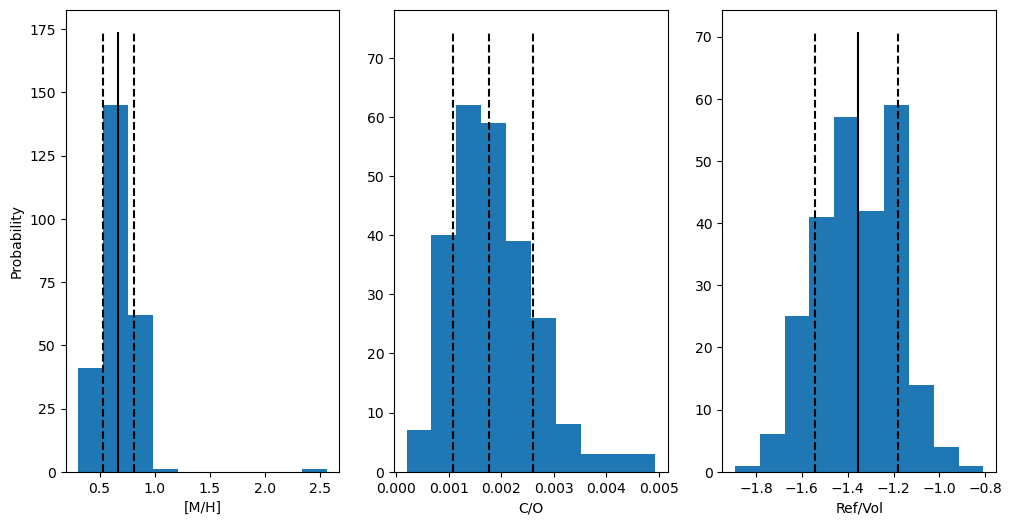

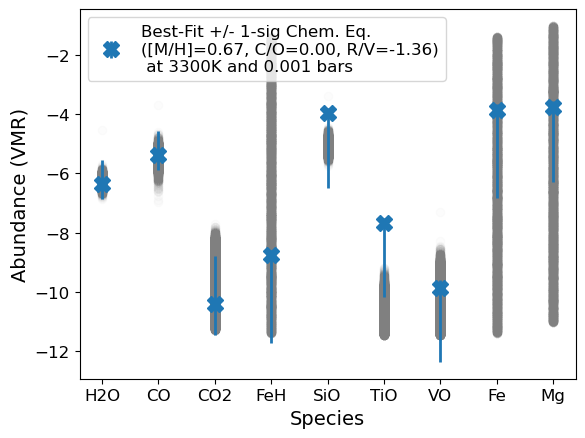

In [16]:
g.species_abunds = median_dict
g.species_errs = posterior_dict_vmr
popt,pcov,best_fit = g.convert_species_abunds(3300, 1e-3, plot_it=True,fit_refvol=True, posterior_samples=250)

TiO appears to be depleted relative to our chemical equilibrium expectations. This is seen in measurements of other planets too (CITE). It seems likely that some cold-trapping process is depleting Ti-species. Let's run again, without TiO since we have a prior expectation that our measurement of its abundance in WASP-178b may not be representative of the planet's bulk composition.

Running on 250 samples... May take a moment if >10
---
Metallicity - Median: 0.7822, Lower bound: 0.6345, Upper bound: 0.9302
C/O - Median: 0.0013, Lower bound: 0.0008, Upper bound: 0.0020
Ref/Vol - Median: -1.2068, Lower bound: -1.3802, Upper bound: -1.0255
---
Median Fit Abundances
---
H2O: -6.250378303101885
CO: -5.376918895949246
SiO: -3.819945190561943
CO2: -10.311910699657167
FeH: -8.64607112478371
Fe: -3.7300604179949706
Mg: -3.6368915985861765
VO: -9.629771362533388
Updating bulk abundances with mean/median fit


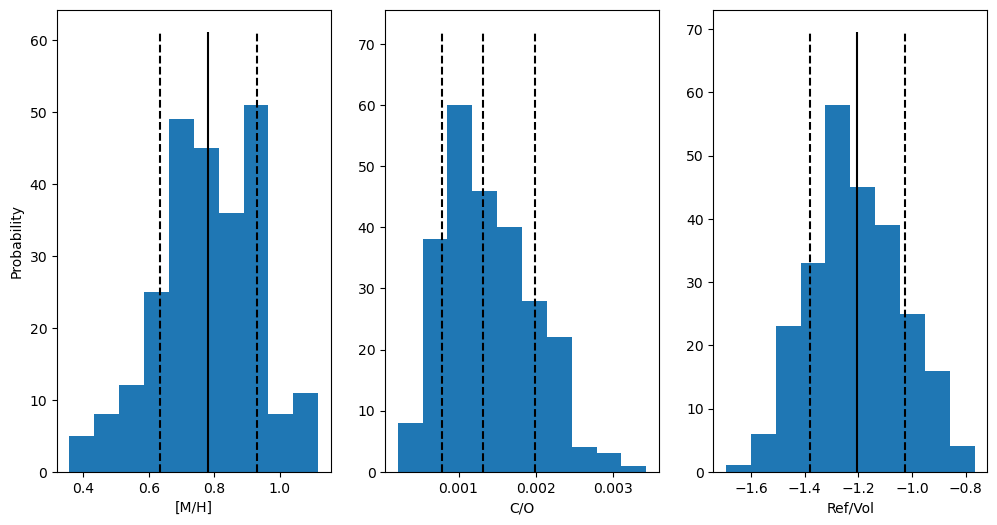

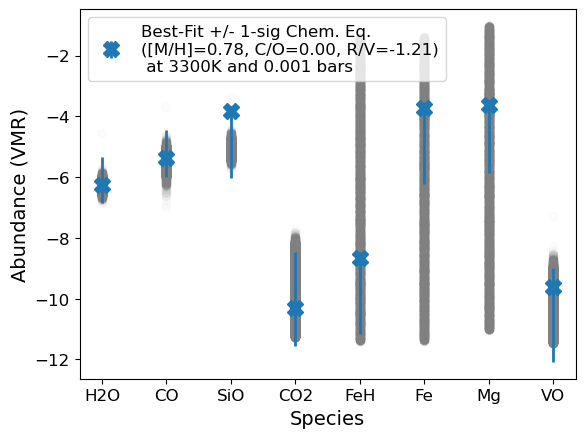

In [17]:
#Try without TiO
ss = ['H2O','CO','SiO','CO2','FeH','Fe','Mg','VO']
median_dict_tmp = {}
posterior_dict_vmr_tmp = {}
for s in ss:
    median_dict_tmp[s] = median_dict[s]
    posterior_dict_vmr_tmp[s] = posterior_dict_vmr[s]
g.species_abunds = median_dict_tmp
g.species_errs = posterior_dict_vmr_tmp
popt,pcov,best_fit = g.convert_species_abunds(3300, 1e-3, plot_it=True,fit_refvol=True, posterior_samples=250)

Nice! The best-fit values are pretty consistent with the chemical equilibrium retrievals, which found [O/H] = $0.4^{+0.45}_{-0.43}$, C/O = $0.01^{+0.01}_{-0.00}$, and [Si/O] = $-0.18 \pm 0.49$. The constraints from the chemical equilibrium retrieval are less constraining because they marginalize over the uncertainty in the temperature which is really important (see below)!

A few caveats: 1) The R/V found here adds the contribution of the other refractories, including TiO, which is likely cold-trapped (CITE Pelletier, Gandhi) so it is no surprise that we find a somewhat lower R/V compared to the Si/O measured in the chemical equilibrium retrievals. 2) As described above, these results are sensitive to the temperature and pressure we assume, which is especially true here because of thermal dissociation. If the temperature was a bit higher, we'd infer a higher [O/H] because there'd be more dissociation, while for a lower temperature, we'd infer the opposite. E.g.:

In [18]:
print('100 K Hotter')
popt,pcov,best_fit = g.convert_species_abunds(3400, 1e-3, plot_it=False,fit_refvol=True, posterior_samples=250)

print('\n100 K Cooler')
popt,pcov,best_fit = g.convert_species_abunds(3200, 1e-3, plot_it=False,fit_refvol=True, posterior_samples=250)

100 K Hotter
Running on 250 samples... May take a moment if >10
---
Metallicity - Median: 1.2297, Lower bound: 1.0783, Upper bound: 1.3823
C/O - Median: 0.0004, Lower bound: 0.0003, Upper bound: 0.0006
Ref/Vol - Median: -1.6964, Lower bound: -1.8466, Upper bound: -1.5104
---
Median Fit Abundances
---
H2O: -6.261110787335154
CO: -5.427014153206894
SiO: -3.3565729191488876
CO2: -10.163087975586826
FeH: -8.291020804423605
Fe: -3.2855582964737575
Mg: -3.1935768212053146
VO: -9.039244973932497
Updating bulk abundances with mean/median fit

100 K Cooler
Running on 250 samples... May take a moment if >10
---
Metallicity - Median: 0.3300, Lower bound: 0.1807, Upper bound: 0.4545
C/O - Median: 0.0037, Lower bound: 0.0023, Upper bound: 0.0057
Ref/Vol - Median: -0.7494, Lower bound: -0.9010, Upper bound: -0.5815
---
Median Fit Abundances
---
H2O: -6.2259933252848
CO: -5.3739140806704215
SiO: -4.2859640089453395
CO2: -10.50069854787331
FeH: -9.004392196665476
Fe: -4.180174271396533
Mg: -4.08613858